In [163]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [164]:
import matplotlib.pyplot as plt

In [165]:
import time

In [166]:
##era5 level
level = [100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

In [167]:
#Build dataset function
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [168]:
with open('data_theta_profile.pkl', 'rb') as f:
    profile =  pickle.load(f)
with open('data_inversion_label.pkl', 'rb') as f:
    label =  pickle.load(f)

In [169]:
print(level[11:])
print(profile.shape)
print(profile[402,:])
profile_1 = profile[:,11:]
print(profile_1.shape)
print(profile_1[402,:])

[500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
(9417, 27)
[373.41051486 361.60807603 356.81022406 352.96333721 348.97525211
 346.08166219 344.8031223  341.16984783 337.00088876 328.09981433
 323.1965185  321.83354057 319.69193004 316.0600125  312.89043531
 310.38657406 307.57157907 305.51929852 303.30526766 300.99947672
 300.08485932 298.98309837 297.43687628 296.57633865 294.11825979
 292.26140473 292.31802017]
(9417, 16)
[321.83354057 319.69193004 316.0600125  312.89043531 310.38657406
 307.57157907 305.51929852 303.30526766 300.99947672 300.08485932
 298.98309837 297.43687628 296.57633865 294.11825979 292.26140473
 292.31802017]


In [170]:
x_train, x_test, y_train, y_test = train_test_split(profile_1, label, test_size=0.25, random_state=52)

In [171]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [172]:
train_data = TrainData(torch.FloatTensor(x_train), 
                       torch.FloatTensor(y_train))
test_data = TrainData(torch.FloatTensor(x_test), 
                       torch.FloatTensor(y_test))

In [173]:
label_class,count = np.unique(label,return_counts=True)
print(label_class )

[0 1]


In [174]:
label_class_train,count_train = np.unique(train_data[:][1],return_counts=True)
print(label_class_train,count_train)
label_class_test,count_test = np.unique(test_data[:][1],return_counts=True)
print(label_class_test,count_test)

[0. 1.] [1995 5067]
[0. 1.] [ 678 1677]


In [175]:
kk = train_data[:][1]

In [176]:
print(int(kk[0]))
print(int(kk[5001]))

1
0


In [177]:
class_weights = [sum(count_train)/c for c in count_train]
print(class_weights)

[3.5398496240601505, 1.3937240970988751]


In [178]:
#class_weights  = [0.9,0.032]

In [179]:
example_ratio = np.zeros((7062))
for k in range(0,len(train_data[:][1])):
    example_ratio[k] = class_weights[int(train_data[k][1])]
print(example_ratio[0:10])

[1.3937241  1.3937241  1.3937241  1.3937241  1.3937241  1.3937241
 1.3937241  3.53984962 1.3937241  1.3937241 ]


In [180]:
sampler = WeightedRandomSampler(example_ratio,len(train_data[:][1]))

In [43]:
### balance data
train_loader = DataLoader(dataset=train_data,sampler=sampler, batch_size=32)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [181]:
### no balance data
train_loader = DataLoader(dataset=train_data,shuffle=True, batch_size=32)
test_loader = DataLoader(dataset=test_data, shuffle=True,batch_size=1)

In [182]:
total_num_images = len(train_loader.dataset)
print(total_num_images)

7062


In [183]:
total = 0
for batch, (X,y) in enumerate(train_loader):
    total = sum(y) +total
print(total)

tensor(5067.)


In [184]:
# 定義類神經網路模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # 建立類神經網路各層
        self.flatten = nn.Flatten()  # 轉為一維向量
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 128), 
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # 定義資料如何通過類神經網路各層
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [185]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [186]:
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [187]:
# 損失函數
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()
# 學習優化器
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [188]:
# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 將模型設定為訓練模式
    model.train()
    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y.unsqueeze(1)) # 計算損失值（loss）
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數


In [189]:
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
print(X[0])
print(y.unsqueeze(1))
num_batches = len(test_loader)
size = len(test_loader.dataset)
print(num_batches)
print(size)

tensor([-0.2030, -0.0427,  0.0360,  0.1285, -0.0743, -0.8450, -0.9006, -0.6968,
        -0.6183, -0.5655, -0.6574, -0.8313, -0.9142, -0.8314, -0.7825, -0.7451])
tensor([[1.]])
2355
2355


In [190]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)
    # 將模型設定為驗證模式
    model.eval()
    # 批次數量
    num_batches = len(dataloader)
    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()

            # 計算預測正確數量的加總值
            y_pred_tag = torch.round(torch.sigmoid(pred))
            correct_results_sum = (y_pred_tag ==y.unsqueeze(1)).sum().float()
            acc = correct_results_sum#/y_test.shape[0]
    #acc = torch.round(acc * 100)
            correct += correct_results_sum.type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss , correct*100

In [191]:
# 設定 epochs 數
epochs = 200
st_time = time.time()
total_trainloss = np.zeros((epochs)) 
total_testloss = np.zeros((epochs)) 
total_acc = np.zeros((epochs)) 
# 開始訓練模型
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    trainloss,acc1 = test(train_loader, model, loss_fn)
    testloss,acc = test(test_loader, model, loss_fn)
    total_trainloss[t] = trainloss
    total_testloss[t] = testloss
    total_acc[t] = acc
cost_time = time.time() - st_time
print('Total time use',cost_time)
#acc_diff = total_acc[29] - 80.6
#trainloss_diff = total_trainloss[29] - 0.5264
#testloss_diff = total_testloss[29] - 0.5513
#time_diff = cost_time - 486.8
#print('acc diff',acc_diff)
#print('train loss diff',trainloss_diff)
#print('test loss diff',testloss_diff )
#print('time diff',time_diff)
#print('done')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 58.7%, Avg loss: 0.663658 

Test Error: 
 Accuracy: 58.9%, Avg loss: 0.662236 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 58.9%, Avg loss: 0.663133 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.661409 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 61.5%, Avg loss: 0.647482 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.645895 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 61.2%, Avg loss: 0.650938 

Test Error: 
 Accuracy: 61.4%, Avg loss: 0.650001 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 61.1%, Avg loss: 0.652832 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.651579 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 62.5%, Avg loss: 0.648551 

Test Error: 
 Accuracy: 62.6%, Avg loss: 0.647808 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 63.4%, Avg loss: 0.640825 

Test Error: 
 Accuracy: 63.1%, Avg loss: 0.6

Test Error: 
 Accuracy: 70.3%, Avg loss: 0.580140 

Epoch 58
-------------------------------
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.566293 

Test Error: 
 Accuracy: 72.1%, Avg loss: 0.567987 

Epoch 59
-------------------------------
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.564241 

Test Error: 
 Accuracy: 71.8%, Avg loss: 0.568200 

Epoch 60
-------------------------------
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.563777 

Test Error: 
 Accuracy: 71.9%, Avg loss: 0.567539 

Epoch 61
-------------------------------
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.571206 

Test Error: 
 Accuracy: 71.3%, Avg loss: 0.573786 

Epoch 62
-------------------------------
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.574463 

Test Error: 
 Accuracy: 70.4%, Avg loss: 0.576476 

Epoch 63
-------------------------------
Test Error: 
 Accuracy: 72.1%, Avg loss: 0.562620 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.566263 

Epoch 64
-------------------------------
Test Error: 
 Accuracy: 72.5%, Avg lo

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.547158 

Test Error: 
 Accuracy: 72.9%, Avg loss: 0.552234 

Epoch 115
-------------------------------
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.556730 

Test Error: 
 Accuracy: 71.3%, Avg loss: 0.562243 

Epoch 116
-------------------------------
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.536639 

Test Error: 
 Accuracy: 73.3%, Avg loss: 0.542627 

Epoch 117
-------------------------------
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.548106 

Test Error: 
 Accuracy: 72.3%, Avg loss: 0.554241 

Epoch 118
-------------------------------
Test Error: 
 Accuracy: 73.8%, Avg loss: 0.543485 

Test Error: 
 Accuracy: 72.6%, Avg loss: 0.550219 

Epoch 119
-------------------------------
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.548561 

Test Error: 
 Accuracy: 72.3%, Avg loss: 0.553966 

Epoch 120
-------------------------------
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.559043 

Test Error: 
 Accuracy: 70.9%, Avg loss: 0.564001 

Epoch 121
----------

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.533771 

Epoch 171
-------------------------------
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.542395 

Test Error: 
 Accuracy: 73.0%, Avg loss: 0.548389 

Epoch 172
-------------------------------
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.537444 

Test Error: 
 Accuracy: 73.2%, Avg loss: 0.544471 

Epoch 173
-------------------------------
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.525280 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.532617 

Epoch 174
-------------------------------
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.520551 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.527441 

Epoch 175
-------------------------------
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.530829 

Test Error: 
 Accuracy: 73.6%, Avg loss: 0.538938 

Epoch 176
-------------------------------
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.534694 

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.541963 

Epoch 177
-------------------------------
Test Error: 
 Accuracy: 74.8%,

In [192]:
model.eval()
pred_result = np.zeros((2355))
truth = np.zeros((2355))
score = np.zeros((2355))
i = 0
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred_result[i] = torch.round(torch.sigmoid(pred))
    score[i] = torch.sigmoid(pred)
    truth[i] = y
    i=i+1

In [193]:
print(pred_result[0:15])
print(truth[0:15])
print(np.min(score))

[1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.08008598536252975


In [195]:
hist_pred = np.histogram2d(pred_result,truth,bins=2)

In [196]:
nparray_h = hist_pred[0]
for i in range(0,2):
    print(nparray_h[:,i])

[493. 185.]
[ 444. 1233.]


In [197]:
acc = (nparray_h[1,1]+nparray_h[0,0]) /(nparray_h[1,1]+nparray_h[0,0]+nparray_h[1,0]+nparray_h[0,1])
print('Accuracy= ',round(acc,3))
prec = (nparray_h[1,1]) /(nparray_h[1,1]+nparray_h[1,0])
print('Precision= ',round(prec,3))
recall = (nparray_h[1,1]) /(nparray_h[1,1]+nparray_h[0,1])
print('Recall= ',round(recall,3))
f1 = (prec*recall)*2/(prec+recall)
print('F1 score= ',round(f1,3))

Accuracy=  0.733
Precision=  0.87
Recall=  0.735
F1 score=  0.797


In [198]:
classes = ['no','have']

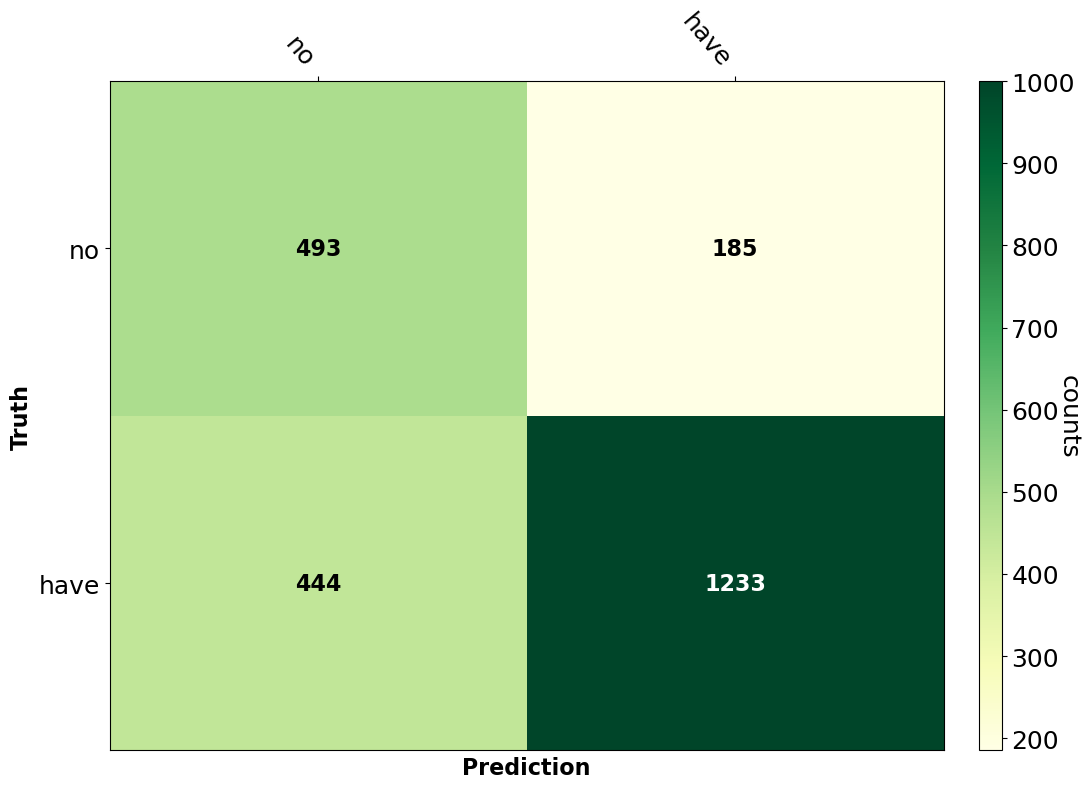

In [199]:
f,ax= plt.subplots(figsize=(11,8))
#ax.hist2d(pred_result, truth,bins=10,cmap='YlGn')
hitplot = ax.pcolormesh(nparray_h.T,cmap='YlGn',vmax=1000)
for xx in range(0,2):
  for yy in range(0,2):
    if nparray_h[xx,yy] > 700:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='w', size=16,fontweight='semibold',ha='center',va='center')
    else:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='k', size=16,fontweight='semibold',ha='center',va='center')
ax.invert_yaxis()
plt.ylabel('Truth',fontsize=16,fontweight='semibold',rotation=90)
plt.xlabel('Prediction',fontsize=16,fontweight='semibold')
plt.xticks(np.arange(0.5,2,1),classes,fontsize=18,rotation=310,horizontalalignment='right')
ax.xaxis.tick_top()
plt.yticks(np.arange(0.5,2,1),classes,fontsize=18)
cb = plt.colorbar(hitplot,aspect=30,fraction=0.03, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('counts', size=18,rotation=270)
plt.tight_layout()
plt.savefig('hw31_heatmap_16level_test2.png',dpi=400)

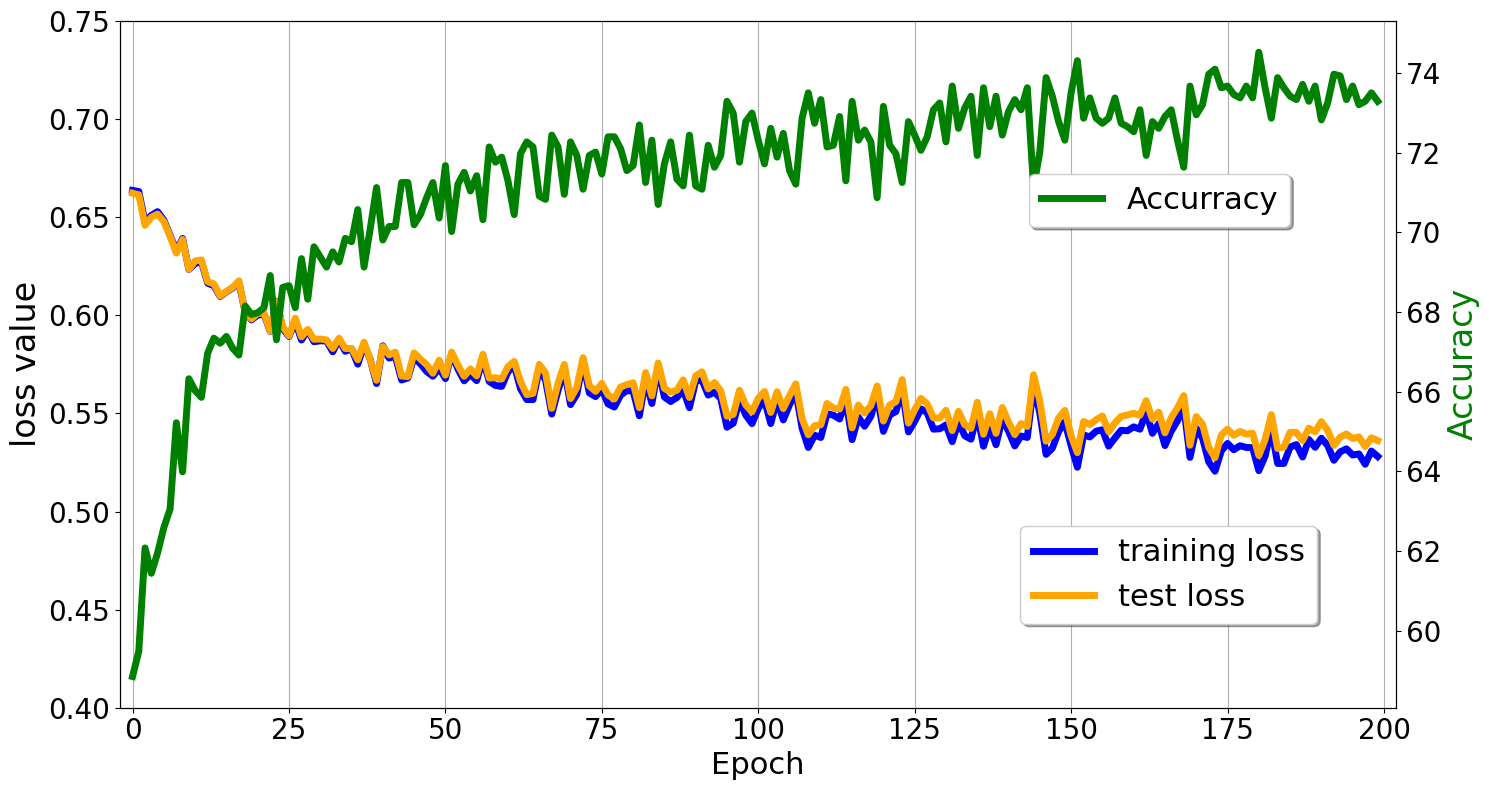

In [200]:
f,ax1= plt.subplots(figsize=(15,8))

ax1.plot(total_trainloss,linewidth=5,c='blue')
ax1.plot(total_testloss,linewidth=5,c='orange')
plt.legend(["training loss","test loss",],fontsize=22,shadow=True,loc=4,bbox_to_anchor=(0.95,0.1))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('loss value',fontsize=24)
ax1.set_xlabel('Epoch',color='k',fontsize=22)
ax1.grid(axis='x')
plt.axis([-2,202,0.4,0.75])


ax2 = ax1.twinx()
ax2.plot(total_acc,linewidth=5,c='green')
plt.ylabel('Accuracy',fontsize=24,c='green')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(["Accurracy"],fontsize=22,shadow=True,loc=2,bbox_to_anchor=(0.7,0.8))
plt.tight_layout()
plt.savefig('hw31_loss_16level_test2.png',dpi=400)



In [201]:
#all_fpr = []
#all_tpr = []
#all_thre = []
#all_roc_auc = []

In [208]:
#ROC_cuv
#ROC score
fpr, tpr, thresholds = roc_curve(truth, score)
roc_auc=roc_auc_score(truth,score)

In [204]:
all_fpr.append(fpr)
all_tpr.append(tpr)
all_thre.append(thresholds)
all_roc_auc.append(roc_auc)

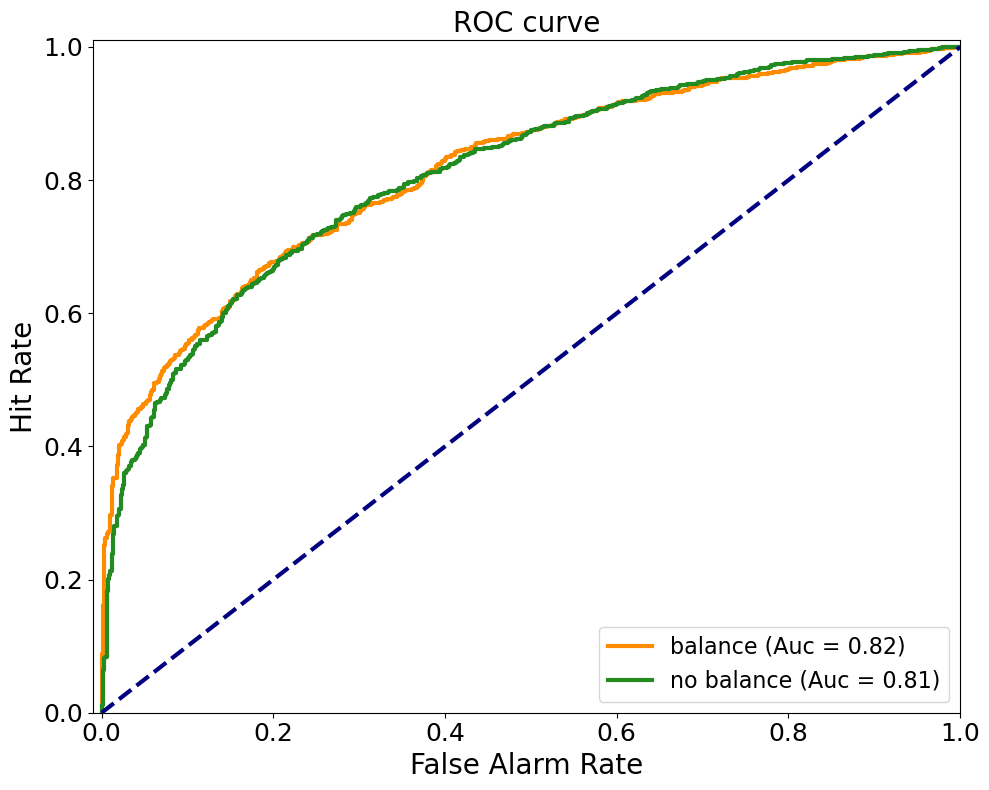

In [207]:
f,ax= plt.subplots(figsize=(10,8))
lw = 3
plt.plot(all_fpr[0],all_tpr[0],color="darkorange",lw=lw,label="balance (Auc = %0.2f)" % all_roc_auc[0],)
plt.plot(all_fpr[1],all_tpr[1],color="forestgreen",lw=lw,label="no balance (Auc = %0.2f)" % all_roc_auc[1],)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Alarm Rate",fontsize=20)
plt.ylabel("Hit Rate",fontsize=20)
plt.title("ROC curve",fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="lower right",fontsize=16)
plt.tight_layout()
plt.savefig('hw31_roc_16level_test.png',dpi=400)

In [103]:
print(thresholds.shape)
print(thresholds[0:20])
print(tpr[0:20])
indy = []
indy.append(np.argmin(abs(thresholds-0.2)))
indy.append(np.argmin(abs(thresholds-0.4)))
indy.append(np.argmin(abs(thresholds-0.6)))
indy.append(np.argmin(abs(thresholds-0.8)))
print(indy)

(702,)
[1.99604756 0.99604756 0.92841119 0.92777741 0.88659769 0.88635486
 0.83812994 0.83795655 0.83320647 0.83316445 0.82988286 0.82955688
 0.82623667 0.82590938 0.82576716 0.82571721 0.81462318 0.8144154
 0.78798687 0.78792143]
[0.         0.0005963  0.08825283 0.08825283 0.16219439 0.16219439
 0.25223614 0.25223614 0.26237329 0.26237329 0.26774001 0.26774001
 0.27191413 0.27191413 0.27310674 0.27310674 0.29755516 0.29755516
 0.34048897 0.34048897]
[613, 323, 139, 18]


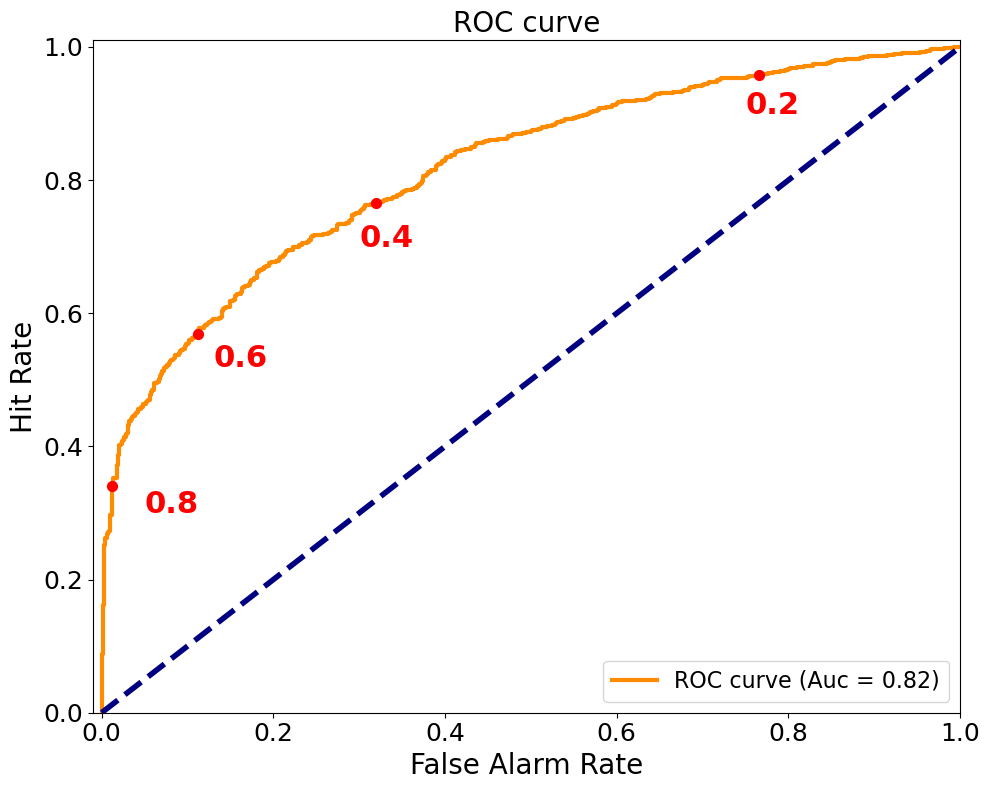

In [124]:
f,ax= plt.subplots(figsize=(10,8))
lw = 3
plt.plot(fpr,tpr,color="darkorange",lw=3,label="ROC curve (Auc = %0.2f)" % roc_auc,)
plt.plot([0, 1], [0, 1], color="navy", lw=4, linestyle="--")
plt.scatter(fpr[indy],tpr[indy],s=50,c='r',zorder=2)
plt.text(0.75,0.9,'0.2',c='r',fontsize=22,fontweight='semibold')
plt.text(0.3,0.7,'0.4',c='r',fontsize=22,fontweight='semibold')
plt.text(0.13,0.52,'0.6',c='r',fontsize=22,fontweight='semibold')
plt.text(0.05,0.3,'0.8',c='r',fontsize=22,fontweight='semibold')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Alarm Rate",fontsize=20)
plt.ylabel("Hit Rate",fontsize=20)
plt.title("ROC curve",fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(loc="lower right",fontsize=16)
plt.tight_layout()
plt.savefig('hw31_roc_16level_test1.png',dpi=400)